# Tutorial 9: Part 5

In [1]:
#import required libraries
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
import pandas as pd
from sklearn.decomposition import PCA

## Example 5: SST
This is the same data as from Tutorial 4 on PCA -- gridded monthly sea surface temperature data in the Tropical Pacific from ERA Interim reanalysis.  Period: Jan 1979 through Jun 2015

In [2]:
#load SST data from .csv file and check it out; rows are months, columns are locations
dataSST = pd.read_csv('SST_anomalies_data.csv',header=None)

#filename = 'SST_ERAInterim_monthly_Jan1979_Jun2017_Tropical_Pacific.nc'
#dataSST = Dataset(filename)
#lonERA = -360+dataSST.variables['longitude'][:] #in degrees E
#latERA = dataSST.variables['latitude'][:] #in degrees N
#timeERA = dataSST.variables['time'][:] #in hours since year 1900... not a great unit, but it's what ERA comes in
#T = dataSST.variables['sst'] #in K

#months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
#SST_extent=[-360+159.75,-360+260.25,-10.5,10.5] #these are just the known boundaries of the SST grid [lonmin,lonmax,latmin,latmax] for plotting

#load coastline data
#coasts = pd.read_csv('coastline.csv',header=None)
#coastLat = coasts[0]
#coastLon = coasts[1]

In [5]:
#do PCA using built-in library

data = dataSST

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(data)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

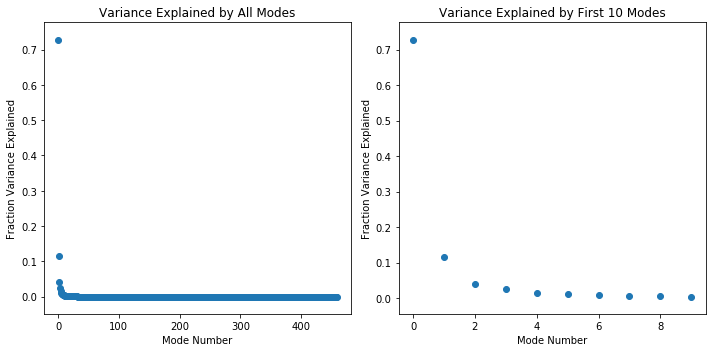

In [6]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')

plt.subplot(1,2,2)
n_modes_show = 10
plt.scatter(range(n_modes_show),fracVar[:n_modes_show])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes')

plt.tight_layout()

plt.show()

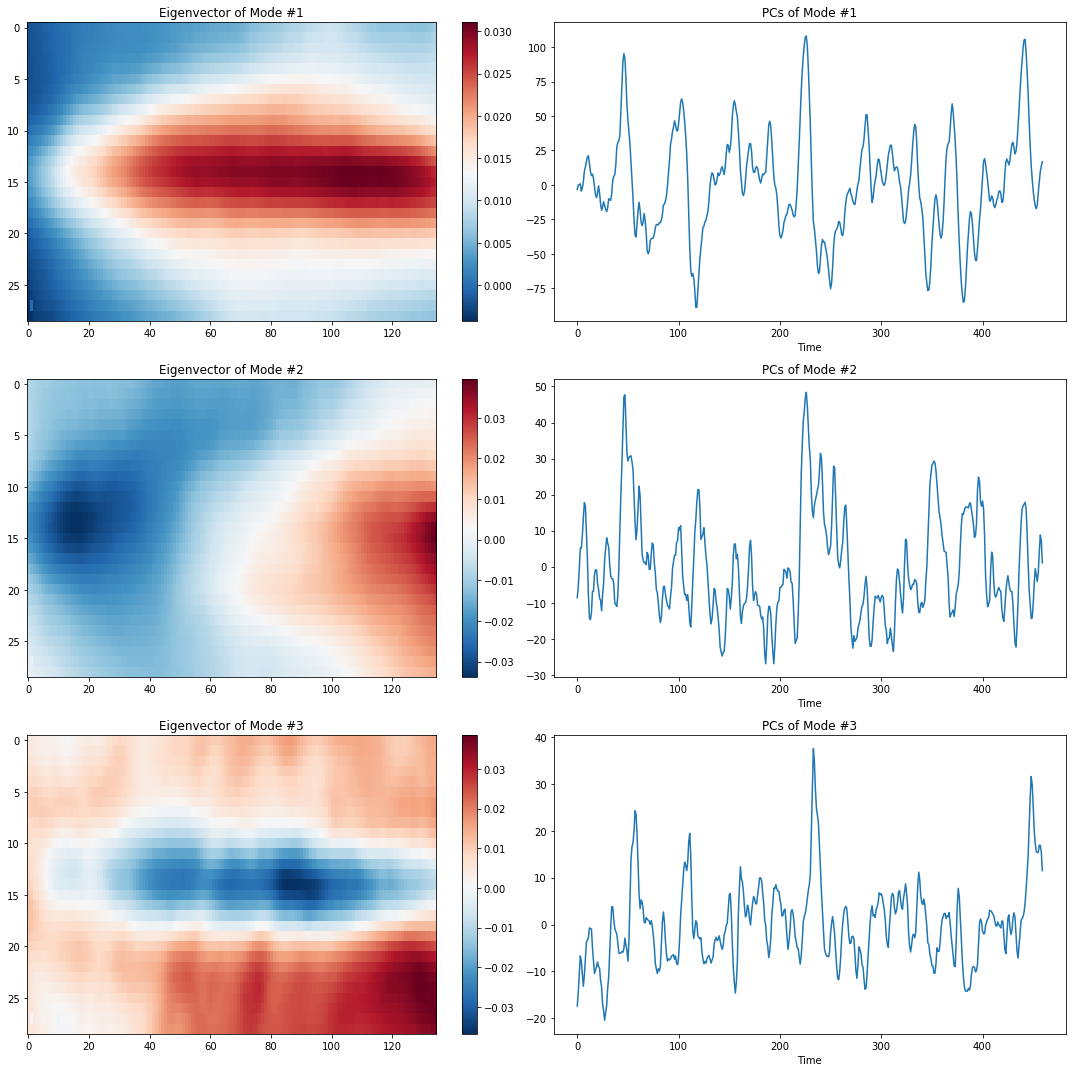

In [11]:
#plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure!

n = 3

plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.imshow(np.reshape(eigvecs[kk,:],(29,135)),cmap = 'RdBu_r',aspect='auto')
    #plt.plot(coastLon,coastLat,c='k')
    #plt.xlim(T_extent[:2])
    #plt.ylim(T_extent[2:])
    plt.title('Eigenvector of Mode #' + str(kk+1))
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Time')
    
    plt.tight_layout()

In [25]:
#run SOM -- this code creates/trains the SOM and calculates stats of interest

nx = 3
ny = 3
N = len(dataSST) #number of observations to use as input to the SOM
data = dataSST.get_values()[-N:]

#make, initialize, and train the SOM
som = MiniSom(nx, ny, len(data[0]), sigma=1., learning_rate=0.5) # initialization of (ny x nx) SOM
som.pca_weights_init(data)
som.train_random(data, 500) # trains the SOM

qnt = som.quantization(data) #this is the pattern of the BMU of each observation (ie: has same size as data input to SOM)
bmu_patterns = som.get_weights() #this is the pattern of each BMU; size = (nx, ny, len(data[0]))
QE = som.quantization_error(data) #quantization error of map
TE = som.topographic_error(data) #topographic error of map

#calculate the BMU of each observation
bmus = []
bmus_num = []
for kk in range(len(data)):
    bmus.append(som.winner(data[kk]))
    num = bmus[kk][0]*nx + bmus[kk][1]
    bmus_num.append(num)
    
#inds gives the sequential coordinates of each SOM node (useful for plotting)
inds = []
for ii in range(ny):
    for jj in range(nx):
        inds.append((ii,jj))
     
#compute the frequency of each BMU
freq = np.zeros((nx,ny))
for bmu in bmus:
    freq[bmu[0]][bmu[1]]+=1
freq/=N

/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.
  


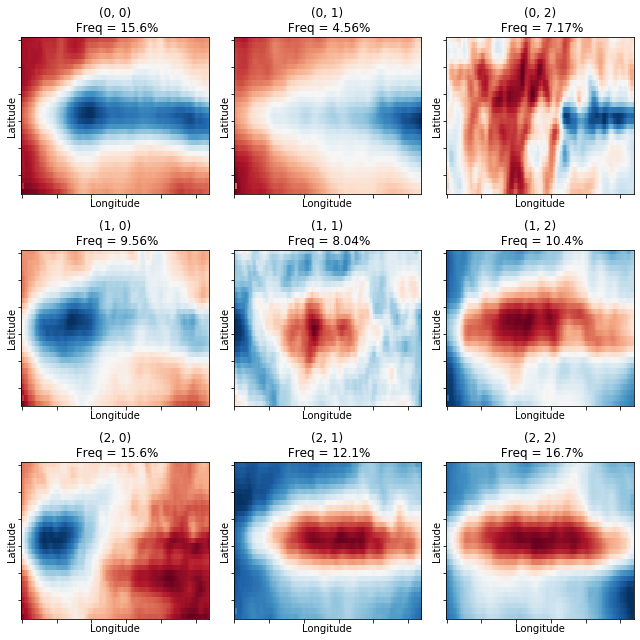

In [26]:
#visualize

plt.figure(figsize=(3*nx,3*ny))
for kk in range(nx*ny):   
    plt.subplot(ny,nx,kk+1)
    indx = inds[kk][1]
    indy = inds[kk][0]
    plt.imshow(np.reshape(bmu_patterns[indx][indy],(29,135)),cmap='RdBu',aspect='auto')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.title(str(inds[kk]) + '\n Freq = ' + str(freq[indx][indy]*100)[:4] + '%')
    
plt.tight_layout()

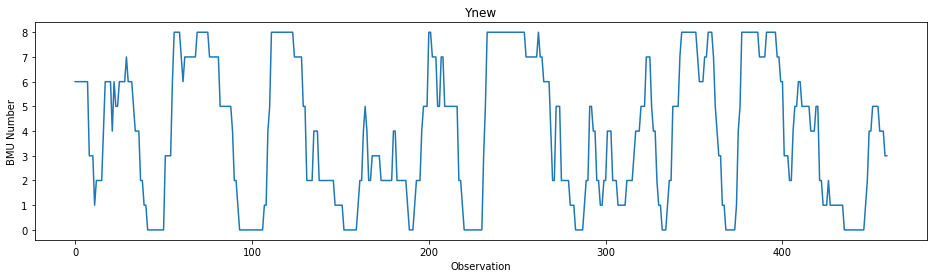

In [27]:
#visualize clustered data
plt.figure(figsize=(16,4))
plt.plot(bmus_num)
plt.xlabel('Observation')
plt.ylabel('BMU Number')
plt.title('Ynew')
plt.show()